In [50]:
using PyPlot

In [83]:
#
# Predictor Corrector method using 4th order
# Adams-Bashforth and Adams-Moulton. Starting
# values computed with Runge Kutta 4th order.
# Parameters:
#   f  - right hand side of ODE
#   t0 - initial time
#   y0 - initial value
#   h  - step size
#   T  - final time
#   k  - number of corrector steps
#
function PECE(f, t0, y0, h, T, k)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)
    fs = zeros(d, N + 1) # value of f at (t[i],y[:,i])
    m = zeros(1, N + 1) # value of Milne's device

    # Initial values:
    t[1] = t0
    y[:,1] = y0
    fs[:,1] = f(t0, y0)

    # Compute the first three steps with RK4:
    for i = 1:min(3, N)
        t[i+1] = t[i] + h
        
        k_1 = f(t[i], y[:,i])
        k_2 = f(t[i] + 0.5*h, y[:,i] + 0.5 * h * k_1)
        k_3 = f(t[i] + 0.5*h, y[:,i] + 0.5 * h * k_2)
        k_4 = f(t[i+1], y[:,i] + h * k_3)
        
        y[:,i+1] = y[:,i] + h * 1/6. * (k_1 + 2*k_2 + 2*k_3 + k_4)
        fs[:,i+1] = f(t[i+1], y[:,i+1])
    end
    
    # For the remaining steps use a PECE scheme:
    for i = 4:N
        t[i+1] = t[i] + h
        
        # Predictor: Adams-Bashforth 4th order
        yP = y[:,i] + h / 24. * (55. * fs[i] - 59. * fs[i-1] + 37. * fs[i-2] - 9. * fs[i-3])
        
        # Now, do k corrector steps:
        yC = yP
        for j = 1:k
            # Estimate:
            fC = f(t[i+1], yC)
            
            # Corrector: Adams-Moulton 4th order
            yC = y[:,i] + h / 24. * (9. * fC + 19. * fs[i] - 5. * fs[i-1] + 1. * fs[i-2])
        end
        
        y[:,i+1] = yC
        fs[:,i+1] = f(t[i+1], y[:,i+1])
        
        # Milne's device:
        m[i+1] = 251. / (251. + 19.) / h * norm(yC - yP)
    end
    
    return (t, y, f, m)
end

PECE (generic function with 2 methods)

In [84]:
#
# (Explicit) Forward Euler scheme:
# f  - rhs of differential equation
# df - Jacobian matrix of f (not used)
# t0 - Initial time
# y0 - Initial value
# h  - step length
# T  - right boundary of time interval [t0,T]
#
function forward_euler(f, df, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)

    # Initial values:
    t[1] = t0
    y[:,1] = y0

    for i = 1:N
        t[i+1] = t[i] + h
        y[:,i+1] = y[:,i] + h * f(t[i], y[:,i])
    end
    
    return (t, y)
end

forward_euler (generic function with 1 method)

In [85]:
#
# Newton's method:
# F  - a vector-valued function
# dF - Jacobian matrix of F
# x0 - a starting vector for the Newton iteration
#
# returns a vector as result
#
function newton(F, dF, x0, precision = 1.e-8)
    x = x0;
    for i = 1:100
        step = - inv(dF(x)) * F(x)
        x = x + step
        if (norm(F(x)) < precision)
            return x
        end
    end
    error("no convergence")
end

newton (generic function with 2 methods)

In [86]:
#
# (implicit) trapezoidal-rule, or Crank-Nicolson scheme:
# f  - rhs of differential equation
# df - Jacobian matrix of f
# t0 - Initial time
# y0 - Initial value
# h  - step length
# T  - right boundary of time interval [t0,T]
#
function crank_nicolson(f, df, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)

    # Initial values:
    t[1] = t0
    y[:,1] = y0

    for i = 1:N
        t[i+1] = t[i] + h
        
        G(z) = y[:,i] + h * 0.5 * (f(t[i+1], z) + f(t[i], y[:,i])) - z
        dG(z) = 0.5 * h * df(t[i+1], z) - eye(d)
        y[:,i+1] = newton(G, dG, y[:,i])
    end
    
    return (t, y)
end

crank_nicolson (generic function with 1 method)

In [87]:
f(t, x) = [
    -200 * t * x[1]^2;
]

x(t) = 1 / (1 + 100*t^2)

t0 = -3.
y0 = [ 1./901; ]
T = 3.;

In [88]:
for i=1:6
    h=0.4/(2^i)
    t,y,f,m = PECE(f, t0, y0, h, T, 1)
    error1=norm(x(T)-y[:,end])
    println("h = ",h)
    println("4th oder 1 correct step error = ", error1)
end


h = 0.2
4th oder 1 correct step error = NaN
h = 0.1
4th oder 1 correct step error = NaN
h = 0.05
4th oder 1 correct step error = 6.670029152441664e-5
h = 0.025
4th oder 1 correct step error = 8.692544600785723e-10
h = 0.0125
4th oder 1 correct step error = 1.4968234984813478e-13
h = 0.00625
4th oder 1 correct step error = 1.0542781925249045e-14


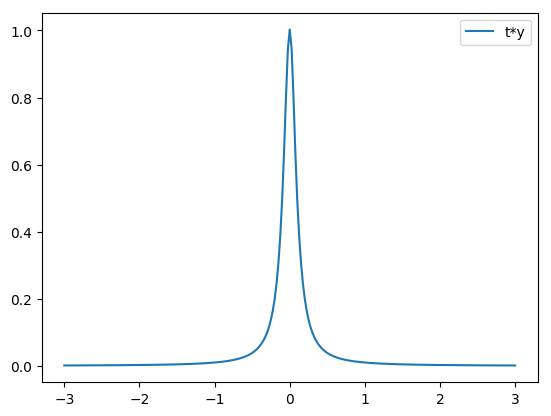

PyObject <matplotlib.legend.Legend object at 0x7f754791f090>

In [89]:
h=0.025
t,y,f,m = PECE(f, t0, y0, h, T, 1)
plot(t',y[1,:],label="t*y")
legend()


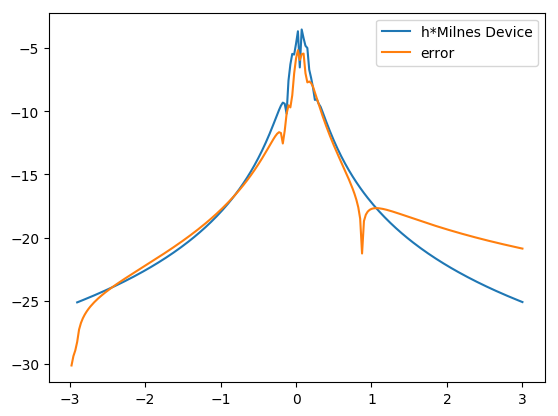

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] include_string(::Module, ::String, ::String) at /home/juser/.julia/v0.6/Compat/src/Compat.jl:464
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[59], in expression starting on line 2


PyObject <matplotlib.legend.Legend object at 0x7f7548c00990>

In [59]:
error = [ norm(x(t[i]) - y[:,i]) for i=1:length(t)]
plot(t',log(h*m[1,:]),label="h*Milnes Device")
plot(t', log.(error), label="error")
legend()


In [60]:
A = [
    -21   19  -20;
     19  -21   20;
     40  -40  -40;
]

f(t, x) = A * x
df(t, x) = A
t0=0
y0=[1.;0.;-1.]
T=2


2

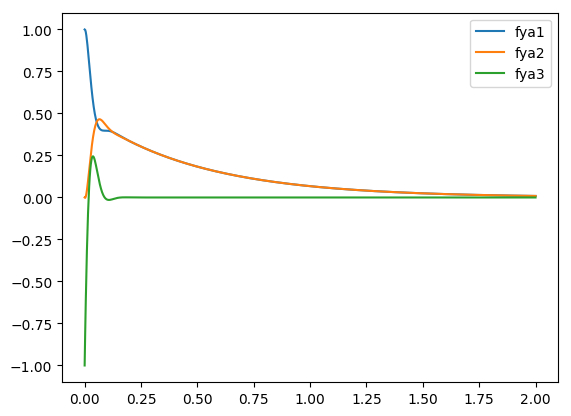

PyObject <matplotlib.legend.Legend object at 0x7f7547d3e410>

In [74]:
h=0.0025
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=crank_nicolson(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

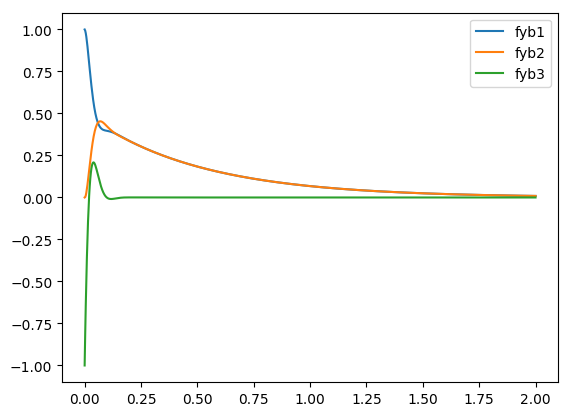

PyObject <matplotlib.legend.Legend object at 0x7f7547c36390>

In [75]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

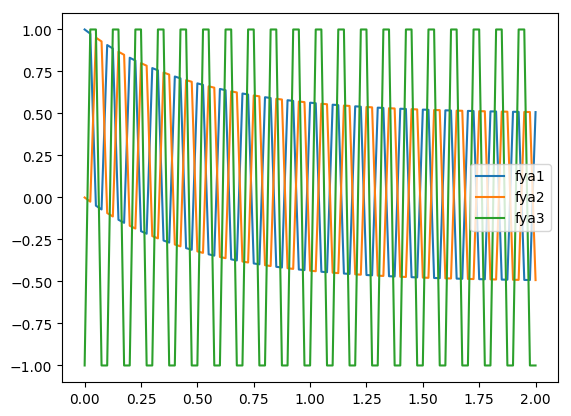

PyObject <matplotlib.legend.Legend object at 0x7f7547a11850>

In [77]:
h=0.025
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=crank_nicolson(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

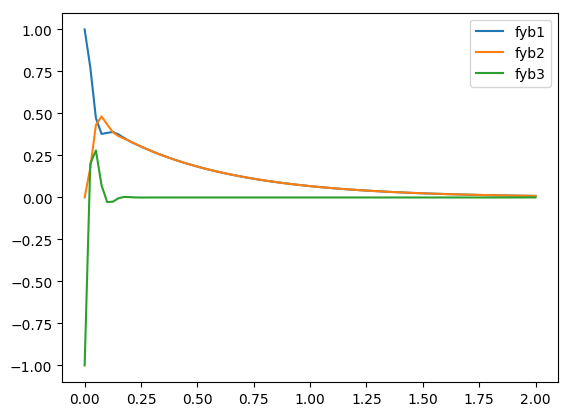

PyObject <matplotlib.legend.Legend object at 0x7f7548b49d90>

In [64]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

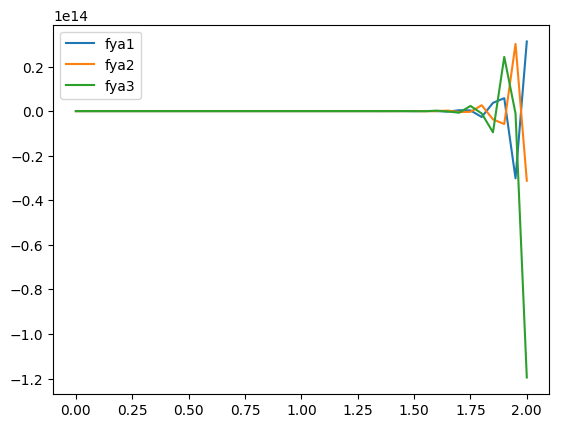

PyObject <matplotlib.legend.Legend object at 0x7f754875cbd0>

In [68]:
h=0.05
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=crank_nicolson(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

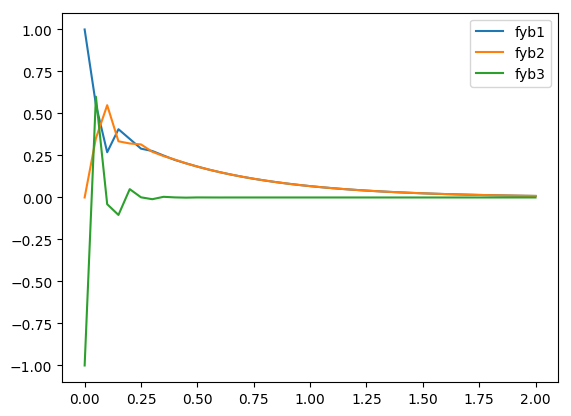

PyObject <matplotlib.legend.Legend object at 0x7f7548181a50>

In [69]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

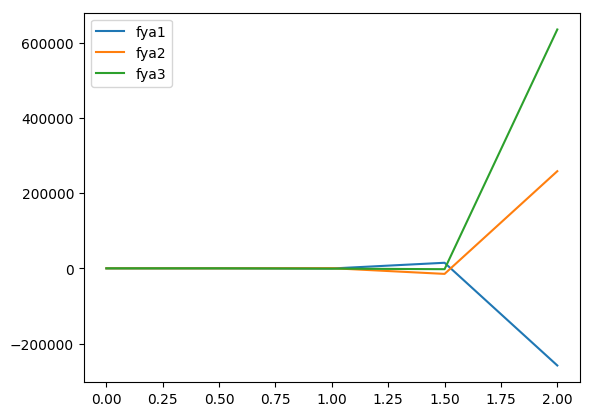

PyObject <matplotlib.legend.Legend object at 0x7f7548580a10>

In [70]:
h=0.5
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=crank_nicolson(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

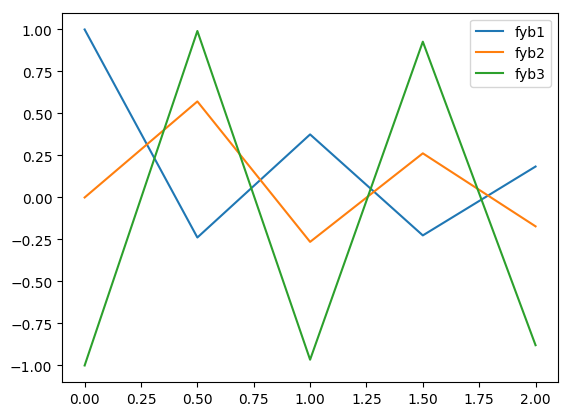

PyObject <matplotlib.legend.Legend object at 0x7f75482e30d0>

In [71]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

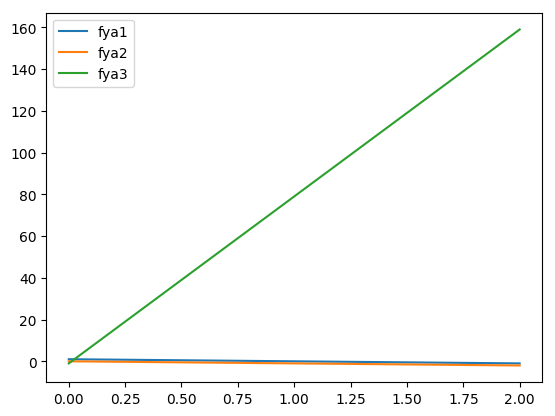

PyObject <matplotlib.legend.Legend object at 0x7f7547ed2510>

In [72]:
h=2
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=crank_nicolson(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

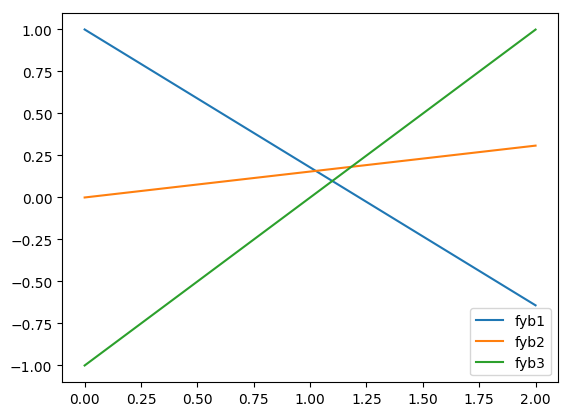

PyObject <matplotlib.legend.Legend object at 0x7f7547e48490>

In [73]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

In [67]:
ω(z) = 1. + z + 1./2 * z^2
function check_point(z)
    if abs(ω(z)) <= 1
        return 0
    else
        return 1
    end
end

check_point (generic function with 1 method)

In [22]:
compute_stability_region(lower_left, upper_right, resolution=800) =
[ check_point(complex(j,i))
    for i = linspace(upper_right.im, lower_left.im, resolution),
        j = linspace(lower_left.re, upper_right.re, resolution)
]

compute_stability_region (generic function with 2 methods)

In [23]:
(lower_left, upper_right) = (-4-4im, 4+4im)
S = compute_stability_region(lower_left, upper_right);

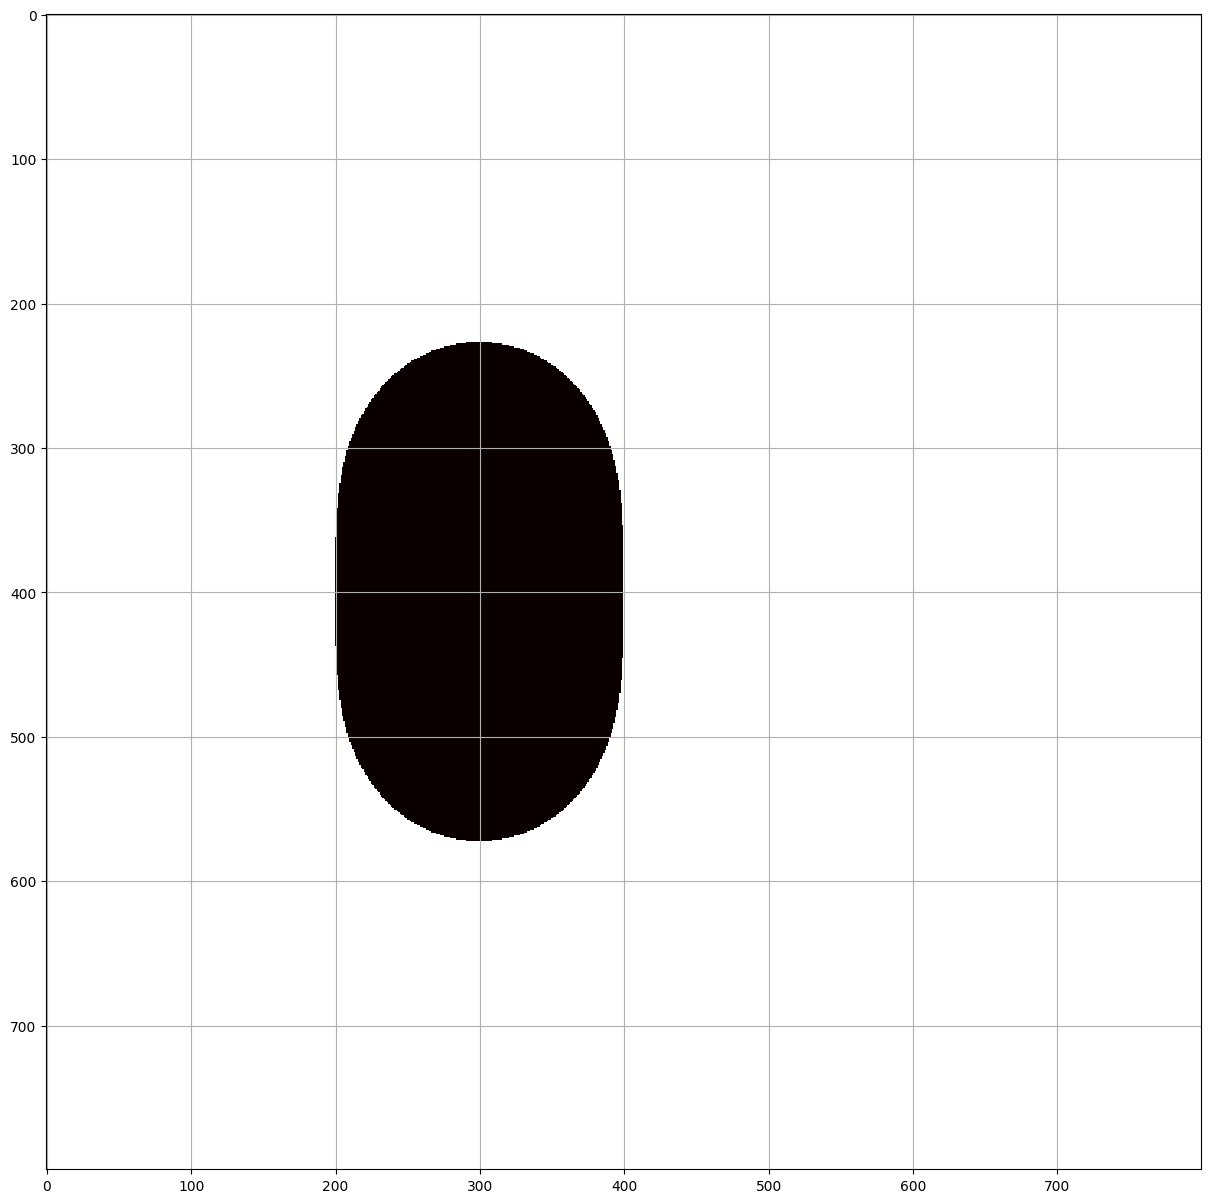

In [81]:
figure(figsize=(15,15))
grid()
imshow(S, cmap="hot");